# NBA Rookie Career Prediction - Modelling with PyCaret
by Kevin Götz 

## Short Description

From the PyCaret-webpage:
PyCaret is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment [[1]](https://pycaret.org/). 

Pycaret is especially useful for a quick Model Comparison to then choose the model with the highest potential for a deep dive with sklearn. In this project I did both: The whole Modelling with PyCaret and additioanlly with sklearn for comparison. PyCaret wins in speed (development / coding) by margins, but sklearn gives you more control over the internals of the pipeline and assumes a deeper understanding of the ML process. 

Combining both approaches could be crucial for future projects. The documentation for Regression Predictions can be found [here](https://pycaret.readthedocs.io/en/latest/api/regression.html).

## Table of Contents

1. Import Libraries & Load Data
2. Data Preprocessing
3. Model Comparison
4. Model Training & Tuning
5. Model Evaluation
6. Model Finalization 
7. Current Rookie Prediction
8. Conclusion

## 1. Import Libraries and Load Data

Not much to laod since PyCaret takes care of almost anything. To get PyCaret running you should set up a venv with python 3.8 and make a full install (pip install pycaret[full]) to get all relevant libraries. Unsolved dependencies between newer versions of Python and sklearn (especially) prohibit a working library without venv on py -3.8 on windows.

In [67]:
# PyCaret Regression functions
from pycaret.regression import *

# Data Munging
import pandas as pd 
pd.set_option('display.max.columns', None)
pd.set_option('display.precision', 2)

import numpy as np 

In [68]:
# load the training & test data
veterans_train = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans_Train.csv', index_col=0)
veterans_test = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans_Test.csv', index_col=0)

# combine because PyCaret handles the splitting
veterans = pd.concat([veterans_train, veterans_test], axis=0)
veterans.head()

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
413,Zaza Pachulia,42.0,Ulkerspor,Other Team/Club,19.0,ORL,C,59.0,2.0,11.3,1.2,0.39,0.0,NaN,1.2,0.39,0.39,1.0,0.64,1.2,1.8,0.2,0.4,0.2,0.6,1.5,3.3,10.8,0.3,2.30e-02,14.6
195,Jordan Crawford,27.0,Xavier,College/University,22.0,TOT,SG,42.0,18.0,24.5,4.6,0.38,0.8,0.26,3.8,0.43,0.42,1.7,0.87,0.7,1.8,2.8,0.9,0.1,2.0,1.5,11.7,11.8,-0.6,-2.60e-02,14.1
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03,24.0
92,Shabazz Muhammad,14.0,California-Los Angeles,College/University,21.0,MIN,SG,37.0,0.0,7.8,1.5,0.46,0.1,0.27,1.5,0.48,0.47,0.7,0.65,0.6,0.8,0.2,0.2,0.0,0.4,0.6,3.9,13.1,0.3,5.30e-02,15.9
146,Brandon Knight,8.0,Kentucky,College/University,20.0,DET,PG,66.0,60.0,32.3,4.8,0.41,1.6,0.38,3.2,0.43,0.48,1.6,0.76,0.5,2.7,3.8,0.7,0.2,2.6,2.3,12.8,11.7,1.3,2.90e-02,13.7


## 2. Data Preprocessing

The whole preprocessing (training environment and transformation pipeline) is defined in the setup-function. There are a lot of opportunities in customizing this step to the data, but only a few of them were needed for this project. It takes two mandatory parameters: data and target. All the other parameters are optional. Only non-default parameters are defined and shown here! The setup function get's called internally when training / tuning / finalizing the model.

The Yeo-Johnson PowerTransformer was chosen because of the EDA showing that most of the features a re not normally distributed. Also the "numberPickOverall" was not recognized as an ordinal variable due to its float dtype and is therefore defined separately in the setup. Lastly the feature "nameOrganizationFrom" was marked as a high cardinality feature in order to be replaced with the frequency of values in each level occurring in the training dataset. 

In [77]:
# setup for the regression analysis

reg = setup(data=veterans,
            ignore_features=['namePlayer'],
            ignore_low_variance=True,
            transformation=True,
            target='Career_PER',
            ordinal_features={'numberPickOverall': list(set(veterans.numberPickOverall))},
            high_cardinality_features=['nameOrganizationFrom'],
            transform_target=True,
            transform_target_method='yeo-johnson',
            # remove_outliers=True,
            # outliers_threshold=0.1,  # after testing variations: most models perform better with the anomalies detected in the EDA
            session_id=1,
            fold=5,  # less folds because of small sample size
            silent=True)

,Description,Value
0,session_id,1
1,Target,Career_PER
2,Original Data,"(507, 31)"
3,Missing Values,True
4,Numeric Features,25
5,Categorical Features,4
6,Ordinal Features,True
7,High Cardinality Features,True
8,High Cardinality Method,frequency
9,Transformed Train Set,"(354, 73)"


In [33]:
# the pipeline looks like this
reg[40]

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['namePlayer'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Career_PER', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,...
                                                  random_state_quantile=1,
                                                  target='Career_PER')),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Career_P

In [37]:
# the tranformed train df with now 71 columns looks like this
reg[21]

,numberPickOverall,nameOrganizationFrom,Age,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,typeOrganizationFrom_College/University,typeOrganizationFrom_High School,typeOrganizationFrom_Other Team/Club,typeOrganizationFrom_not_available,Tm_ATL,Tm_BOS,Tm_CHA,Tm_CHH,Tm_CHI,Tm_CHO,Tm_CLE,Tm_DAL,Tm_DEN,Tm_DET,Tm_GSW,Tm_HOU,Tm_IND,Tm_LAC,Tm_LAL,Tm_MEM,Tm_MIA,Tm_MIL,Tm_MIN,Tm_NJN,Tm_NOH,Tm_NOK,Tm_NYK,Tm_OKC,Tm_ORL,Tm_PHI,Tm_PHO,Tm_POR,Tm_SAC,Tm_SAS,Tm_SEA,Tm_TOR,Tm_TOT,Tm_UTA,Tm_VAN,Tm_WAS,Pos_C,Pos_PF,Pos_PFSF,Pos_PG,Pos_SF,Pos_SFSG,Pos_SG
24,0.0,1.83,0.0,1.22,1.53,1.55,2.22,1.35,0.49,5.42e-01,2.31,1.30,1.16,1.53,0.77,1.89,2.79,0.97,0.64,2.01,1.51,1.60,2.06,2.69,2.48,1.47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
249,17.0,-1.37,0.0,0.83,0.44,-0.11,0.29,0.78,-1.07,2.24e-03,0.59,0.48,0.37,0.59,-0.47,1.09,0.34,-1.05,-0.21,1.50,-0.15,0.49,0.27,1.22,0.45,0.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
300,7.0,1.02,0.0,1.00,1.13,1.12,1.13,-0.15,1.04,7.02e-01,1.08,-0.29,-0.13,1.03,0.04,0.68,0.99,0.48,1.05,1.38,1.19,0.99,1.11,0.08,-0.52,-0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
170,52.0,1.83,0.0,-1.67,-1.32,-1.35,-1.42,0.61,-1.07,-1.85e+00,-1.19,1.45,0.18,-0.78,-1.62,-0.70,-1.54,-1.05,-0.21,-1.55,-0.59,-1.83,-1.38,-0.73,-1.00,-0.85,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
190,17.0,1.83,0.0,1.17,0.80,0.72,0.29,-0.13,0.49,8.90e-02,0.31,0.17,-0.13,0.37,0.18,0.11,0.03,1.56,1.38,0.06,1.64,-0.16,0.32,-0.30,-0.69,-0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,38.0,-1.37,0.0,-1.70,-1.32,-1.79,-1.91,-4.71,-0.53,-1.02e+00,-1.94,-4.16,-4.32,-1.01,0.23,-0.96,-2.05,-1.05,-1.02,-1.55,-2.29,-1.25,-1.76,-2.52,-1.38,-2.73,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
408,28.0,0.47,0.0,0.41,0.89,0.81,0.80,-0.04,0.22,2.77e-01,0.93,-0.13,-0.24,0.59,-0.15,1.55,0.99,0.57,1.23,1.24,0.22,0.99,0.72,0.89,1.11,0.66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
360,54.0,-1.37,0.0,-1.99,-1.32,-0.39,0.16,2.97,1.04,2.80e+00,-0.01,3.08,4.02,0.48,2.78,0.42,-1.87,0.17,-2.17,1.08,0.65,0.74,0.32,2.09,-0.79,2.55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
337,17.0,-1.37,0.0,-1.17,-0.41,-0.56,0.01,0.58,-0.11,2.56e-01,0.16,0.66,0.45,-0.04,0.52,-0.96,-0.86,-0.40,-0.21,-0.87,-0.35,-0.56,-0.07,0.25,-0.52,0.04,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3. Model Comparison

Any algorithm could potentially perform good on the data so as a second step after the preprocessing (which is done independent from the algorithm) we compare the most common regression algorithms while modelling them with our data. The sorting of the result table can be adjusted to one of the five metrics MAE, MSE, RMSE, R2, RMSLE or MAPE.
Per default the ranking is on R2 but it is up to the user to pick the most suitable metric and choose a model according to that.

In [38]:
# show the best-performing models
best_models = compare_models(exclude=['lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.0566,7.8298,2.7748,0.3946,0.1749,0.1430,0.1320
et,Extra Trees Regressor,2.1318,8.1368,2.8254,0.3728,0.1773,0.1489,0.1160
catboost,CatBoost Regressor,2.1289,8.2529,2.8463,0.3615,0.1799,0.1486,2.5140
gbr,Gradient Boosting Regressor,2.1762,8.3707,2.8615,0.3557,0.1813,0.1523,0.0580
lightgbm,Light Gradient Boosting Machine,2.1422,8.4492,2.8717,0.3538,0.1831,0.1493,0.0560
br,Bayesian Ridge,2.1759,8.9575,2.9341,0.3285,0.1854,0.1524,0.0120
ada,AdaBoost Regressor,2.1586,8.7338,2.9282,0.3259,0.1855,0.1512,0.0560
xgboost,Extreme Gradient Boosting,2.2883,9.3652,3.0411,0.2686,0.1898,0.1586,0.3320
ridge,Ridge Regression,2.3824,9.9298,3.1042,0.2443,0.1994,0.1674,0.0120
huber,Huber Regressor,2.3801,10.4644,3.1749,0.2108,0.2014,0.1671,0.0280


--> The Random Forest (rf) scored the best and is therefore chosen for further model development

In [39]:
# show the model that performed best
best_models

PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='yeo-johnson',
                                p...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                criterion='mse',
                                                                max_depth=None,
                      

## 4. Model Training & Tuning

In [40]:
# create the best-performing model
rf = create_model('rf', round=2, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.37,11.60,3.41,0.37,0.20,0.15
1,2.14,7.24,2.69,0.43,0.19,0.17
2,1.80,6.05,2.46,0.40,0.15,0.12
3,2.04,8.43,2.90,0.37,0.18,0.14
4,1.94,5.83,2.42,0.41,0.16,0.14
Mean,2.06,7.83,2.77,0.39,0.17,0.14
SD,0.19,2.10,0.36,0.02,0.02,0.01


In [52]:
# tune the model
rf_tuned = tune_model(rf, search_library='scikit-optimize', search_algorithm='bayesian', round=2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.41,11.96,3.46,0.35,0.20,0.15
1,2.15,7.07,2.66,0.44,0.19,0.17
2,1.77,5.87,2.42,0.42,0.15,0.12
3,2.09,8.55,2.92,0.36,0.18,0.15
4,1.86,5.41,2.33,0.45,0.15,0.13
Mean,2.05,7.77,2.76,0.40,0.17,0.14
SD,0.23,2.36,0.41,0.04,0.02,0.02


--> The model got slightly better, from 0.39 to 0.40 (R2).

In [43]:
# the tuned model looks like this
rf_tuned

PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                                max_depth=7, max_features=0.6274238321006947,
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=8.148758986340845e-08,
                                min_impurity_split=None, min_samples_leaf=5,
                                min_samples_split=6,
                                min_weight_fraction_leaf=0.0, n_estimators=146,
                                n_jobs=-1, oob_score=False,
                                power_transfo...
                                                                ccp_alpha=0.0,
                                                                criterion='mae',
                                                                max_depth=7,
                                                                max_features=0.6274238321006947,
                                         

## 5. Model Evaluation

The model evaluation (except SHAP) can also be viewed in an interactive dashboard when calling the function "evaluate_model(rf_tuned)". This dashboard often fails after reopening the notebook because it processes on the fly (lazy), which is not suitable for presentation and therefore the single & static html versions are preferred.


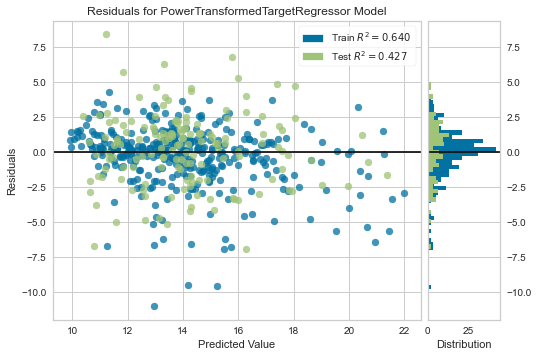

In [44]:
# plot the model for residuals
plot_model(rf_tuned)

--> The residuals are at max. gaussian-like, but not gaussian. The graph shows a right skewed distribution which means that there are higher negative deviations compared to the positive deviations. This means that the model predicts talented players' PER (high PER) worse than untalented players' PER (low PER). Also, the test set shows a flat distribution which means that low and high errors are almost equally likely. Furthermore, the residuals don't seem to be independent: the higher the predicted PER, the higher the negative error, which means the model sees a promised talent in a player in his first year (Rookie) but still underestimates the Career PER of the player..

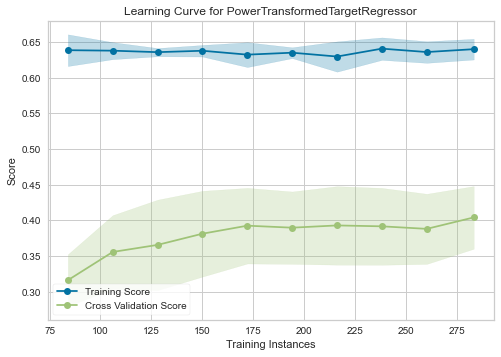

In [51]:
# plot the model for learning curve
plot_model(rf_tuned, plot='learning')

--> Here we can see quite a generalization gap from training to testing (approximately 0.2 R2). The green curve of the cv-score goes up during the last addition of data which indicates that we should use more data that probably boosts the cv-score further towards the train score. 

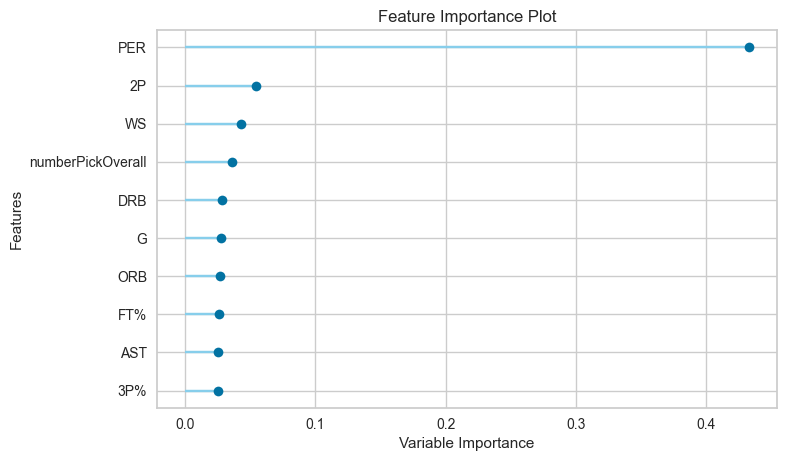

In [53]:
# plot model for (most important) feature importance
plot_model(rf_tuned, plot='feature')

--> The PER in the Rookie year has more than 40% of all the feature importance and is by far the strongest predictor of all the variables, as expected.

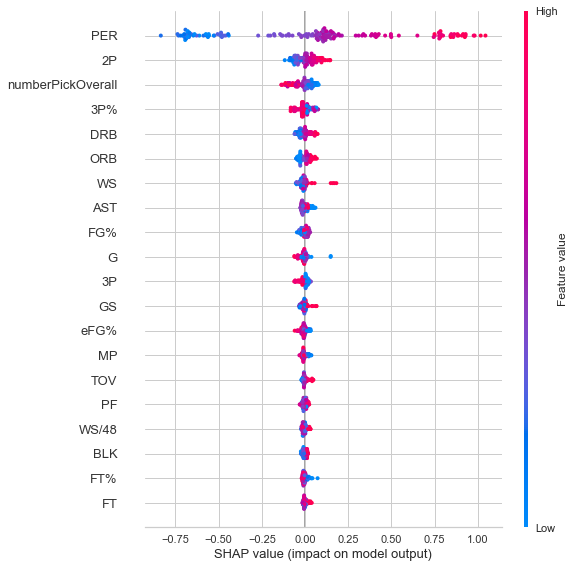

In [56]:
# explain_model with SHAP - summary
interpret_model(rf_tuned, plot='summary')

--> The SHAP graph confirms the strong influence of PER (The spread of the variables scatterplot is the magnitude of the influence). It also shows another dimension in color: how the values (low vs high) impact the target. numberPickOverall is expected to be "invers": The higher the pick, the less the Career PER because the best players get drafted first, starting with 1.

## 6. Model Finalization

In this step the tuned Random Forest gets benchmarked against the test set and finally trained on the whole dataset. As a last step it gets serialized and saved to disc (pickle).

In [59]:
# predict on test set
predictions = predict_model(rf_tuned)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.0494,6.8043,2.6085,0.4274,0.2014,0.1758


--> As seen before the test R2 score is slightly lower than the avg. cv-score from the tuning (0.4 vs. 0.42) which shows that training data and test data are equally representative of the underlying data.

In [60]:
# trains the Random Forest on the entire dataset including the holdout set
finalize_model(rf_tuned)

PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                                max_depth=7, max_features=0.6274238321006947,
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=8.148758986340845e-08,
                                min_impurity_split=None, min_samples_leaf=5,
                                min_samples_split=6,
                                min_weight_fraction_leaf=0.0, n_estimators=146,
                                n_jobs=-1, oob_score=False,
                                power_transfo...
                                                                ccp_alpha=0.0,
                                                                criterion='mae',
                                                                max_depth=7,
                                                                max_features=0.6274238321006947,
                                         

In [61]:
# save the model to disk (pickle file)
save_model(rf_tuned, '../Models/NBA_PyCaret_rf_finalized')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['namePlayer'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Career_PER', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,...
                                                                                  criterion='mae',
                                                                                  max_depth=7,
                                                                                  max_features=0.6274238321006947,

In [62]:
# load model and use again if needed
rf_loaded = load_model('../Models/NBA_PyCaret_rf_finalized')
rf_loaded

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['namePlayer'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Career_PER', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,...
                                                                                 criterion='mae',
                                                                                 max_depth=7,
                                                                                 max_features=0.6274238321006947,
              

## 7. Current Rookie Prediction

In [72]:
# load the Rookie data
rookies = pd.read_csv('../Data/Output/NBA_Player_Stats_Rookies.csv', index_col=0)

# unfortunately there is no way in PyCaret to handle unknown levels with ordinal dtypes, so we have to drop 4 records
rookies = rookies[~rookies.numberPickOverall.isin([54.0, 57.0, 58.0, 59.0])]

# look at data
rookies.head()

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
0,Anthony Edwards,1.0,Georgia,College/University,19.0,MIN,SG,72.0,55.0,32.1,7.0,0.42,2.4,0.33,4.6,0.48,0.49,2.9,0.78,0.8,3.8,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,0.02,13.9
1,James Wiseman,2.0,Memphis,College/University,19.0,GSW,C,39.0,27.0,21.4,4.9,0.52,0.3,0.32,4.6,0.54,0.54,1.4,0.63,1.4,4.4,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,0.04,13.1
2,LaMelo Ball,3.0,Illawarra,Other Team/Club,19.0,CHO,PG,51.0,31.0,28.8,5.7,0.44,1.8,0.35,3.9,0.49,0.50,2.5,0.76,1.2,4.7,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,0.09,17.5
3,Patrick Williams,4.0,Florida State,College/University,19.0,CHI,PF,71.0,71.0,27.9,3.6,0.48,0.8,0.39,2.8,0.52,0.53,1.3,0.73,0.9,3.7,1.4,0.9,0.6,1.4,1.8,9.2,10.5,2.5,0.06,10.5
4,Isaac Okoro,5.0,Auburn,College/University,20.0,CLE,SG,67.0,67.0,32.4,3.5,0.42,0.9,0.29,2.6,0.50,0.48,1.7,0.73,1.0,2.1,1.9,0.9,0.4,1.3,2.8,9.6,7.9,0.9,0.02,7.9


In [75]:
# predict the Career_PER of this years rookies
prediction_rookie = predict_model(rf_loaded, data=rookies)
variables = ['namePlayer', 'numberPickOverall', 'Age', 'Tm', 'Pos', 'Career_PER', 'Label']
result = prediction_rookie[variables].sort_values(by='Label', ascending=False) \
                                     .rename({'Career_PER': 'Rookie_PER', 'Label': 'Predicted_Career_PER'}, axis=1)

# show the Top 10
result.head(10)

,namePlayer,numberPickOverall,Age,Tm,Pos,Rookie_PER,Predicted_Career_PER
2,LaMelo Ball,3.0,19.0,CHO,PG,17.5,18.40
5,Onyeka Okongwu,6.0,20.0,ATL,C,16.8,17.19
15,Isaiah Stewart,16.0,19.0,DET,C,16.4,17.18
11,Tyrese Haliburton,12.0,20.0,SAC,PG,16.2,16.86
23,Immanuel Quickley,25.0,21.0,NYK,PG,15.8,16.07
0,Anthony Edwards,1.0,19.0,MIN,SG,13.9,15.58
19,Precious Achiuwa,20.0,21.0,MIA,PF,14.2,15.57
49,Grant Riller,56.0,23.0,CHO,PG,23.6,15.37
44,Skylar Mays,50.0,23.0,ATL,SG,16.8,15.29
33,Xavier Tillman,35.0,22.0,MEM,PF,14.7,15.27


--> It can be expected that those players will have an acutally higher PER over their Career since the model underestimates high potential (see residual plot) more than low potential. Also the PER Ratings are quite low compared to top notch players currently ranking in 25-27 PER (Lebron James, Kevin Durant, Anthony Davis, etc.).

## 8. Conclusion

This project tried to answer the question: "What is the Career Performance of a Rookie going to be like?". The predictors were player performance metrics from his rookie season, as well as data from the Draft (college, nba team, pick, etc.). The target was the Player Efficiency Rating (PER) averaged over the whole career.

The best model tested was a Random Forest with a R2 of 0.43 (rounded) and "PER" (Rookie Season) as the strongest predictor by far.

Predicting a players career is a hard task because it depends on much more than only his first year stats. Injuries, Lifestyle, Marketing and Teammates all contribute to the long term success of a player and weren't a variable in the prediction model. Furthermore, the data cutoff (veterans >= 5 years of experience) was reasoned but can be extended or lessened for further tests. Also, the players were drafted 2001 or later which could also be extended to get more data and probably are more stable estimator (generalization).